In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
class Curve:
    # Constructor
    def __init__(self, list_of_points, closed=False):
        self.list_of_points = list_of_points
        self.closed = closed
        self.J = len(list_of_points)
    
    # Square Bracket Overload
    def __getitem__(self, key):
        return self.list_of_points[key % self.J]
    def __setitem__(self, key, value):
        self.list_of_points[key] = value
    
    # Length
    def __len__(self):
        return self.J
    
    # Curve Addition
    def __add__(self, otherCurve):
        if len(self) == len(otherCurve) and self.closed == otherCurve.closed:
            return Curve([self[i] + otherCurve[i] for i in range(len(self))])
    
    # Curve Length
    def curveLength(self):
        l = 0
        for i in range(self.J - 1):
            edgeLength = np.linalg.norm(self[i + 1] - self[i])
            l += edgeLength ** 2
        if self.closed:
            edgeLength = np.linalg.norm(self[-1] - self[0])
            l += edgeLength ** 2
        return l
    

In [3]:
# Epsilon is the proportion of the curve length of which gets excluded in the quadrature.
def curveEnergy(curve, epsilon=0.1):
    J = curve.J
    curveLength = curve.curveLength()
    ignoreRange = epsilon * curveLength

    integral = 0
    for i in range(J):
        for j in range(J):
            # Undefined for i = j
            if i == j:
                continue

            contribution = np.linalg.norm(curve[i] - curve[i+1]) * np.linalg.norm(curve[j] - curve[j+1]) / np.linalg.norm(curve[i] - curve[j])
            integral += contribution
    
    return integral
            
    

In [4]:
def curveDifferential(curve, index, perturbation_vec):
    # Perturb the curve in + and - perturb vec.
    # May be improved.
    curvep = Curve(deepcopy(curve.list_of_points))
    curvep[index] += perturbation_vec
    curven = Curve(deepcopy(curve.list_of_points))
    curven[index] -= perturbation_vec

    energyP = curveEnergy(curvep)
    energyN = curveEnergy(curven)
    differential = (energyP - energyN) / 2
    return differential

In [11]:
# Diamond
num_of_verticles = 8
points = []
for i in range(num_of_verticles):
    theta = 2 * np.pi / num_of_verticles * i
    points.append(np.array([np.cos(theta), np.sin(theta), 0]))
curve = Curve(points, True)

In [6]:
curveEnergy(curve)

15.313708498984763

In [7]:
curveDifferential(curve, 0, np.array([0.1,0.0,0]))

0.3821129237404355

In [8]:
def gradientFlow(curve, M=10000, delta_x=0.1, delta_t=0.05, ld=1):
    J = curve.J
    curveN = Curve([np.array([0.0,0.0,0.0]) for i in range(J)])
    for t in range(M):
        for i in range(J):
            curveN[i][0] = curve[i][0] -curveDifferential(curve, i, np.array([delta_x,0.0,0.0])) / delta_x * delta_t - ld * delta_t * curve[i][0]
            curveN[i][1] = curve[i][1] -curveDifferential(curve, i, np.array([0.0, delta_x, 0])) / delta_x * delta_t - ld * delta_t * curve[i][1]
            curveN[i][2] = curve[i][2] -curveDifferential(curve, i, np.array([0.0, 0.0, delta_x])) / delta_x * delta_t - ld * delta_t * curve[i][2]
        curve = curveN
        if (t % 10 == 0):
            plt.plot([curve.list_of_points[i][0] for i in range(J)], [curve.list_of_points[i][1] for i in range(J)])
            plt.xlim((-1, 1))
            plt.ylim((-1, 1))
            plt.show()
            

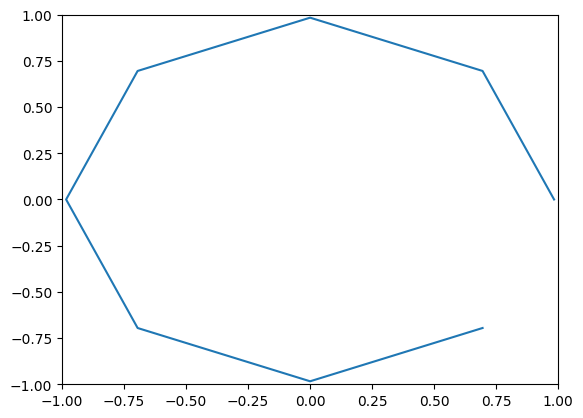

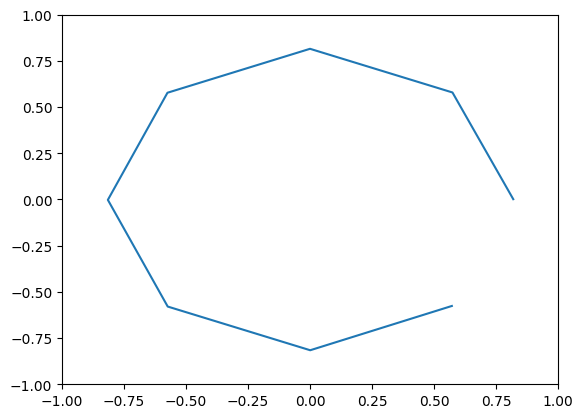

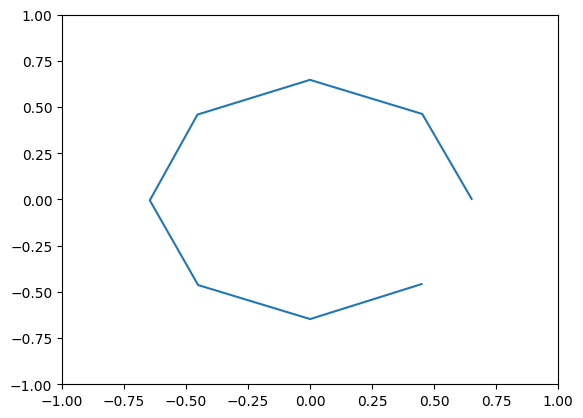

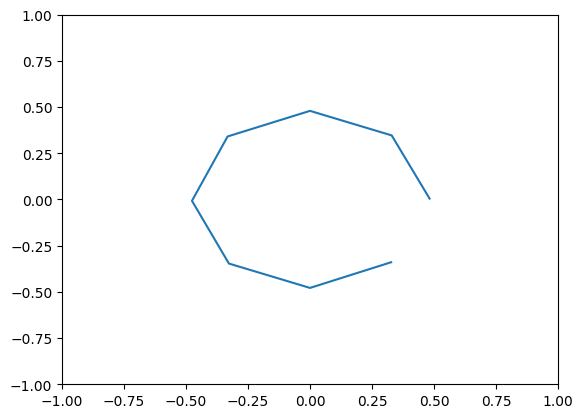

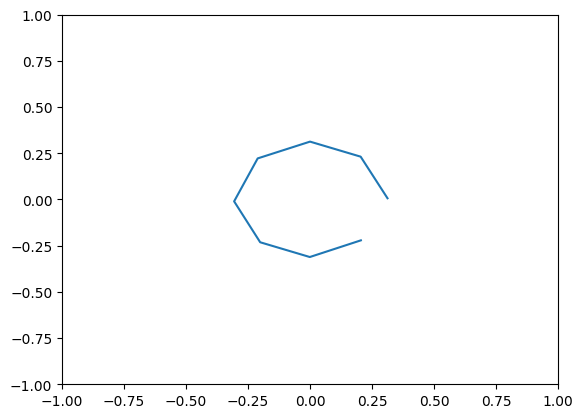

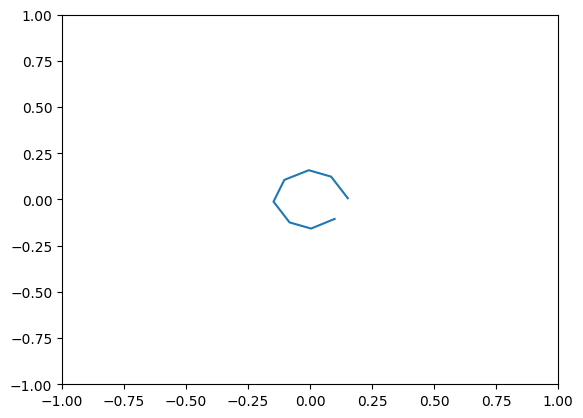

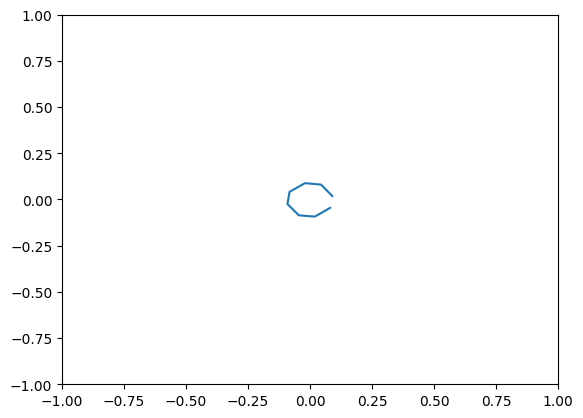

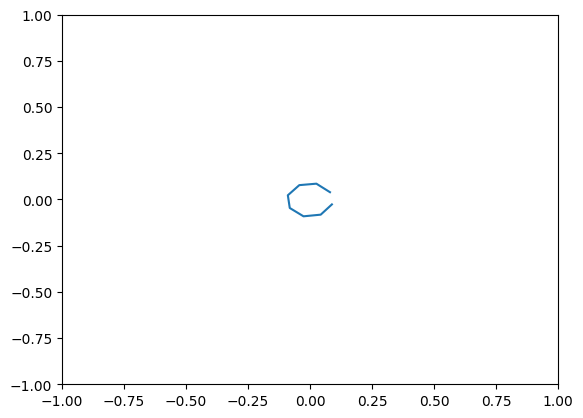

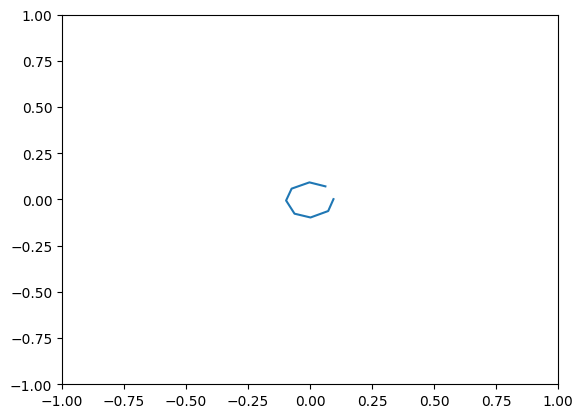

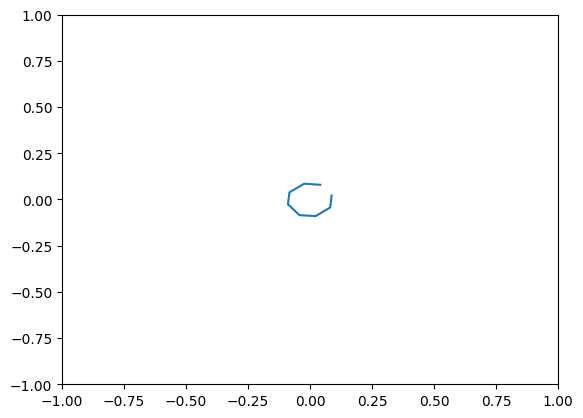

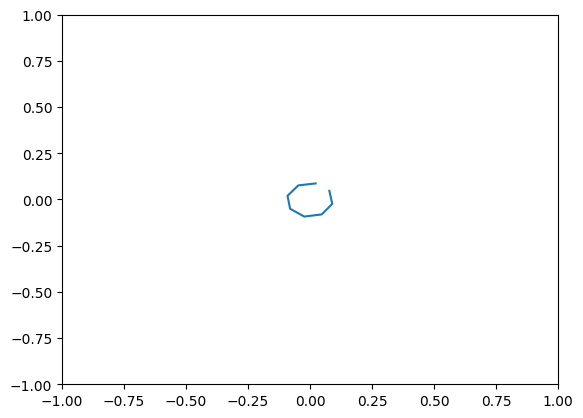

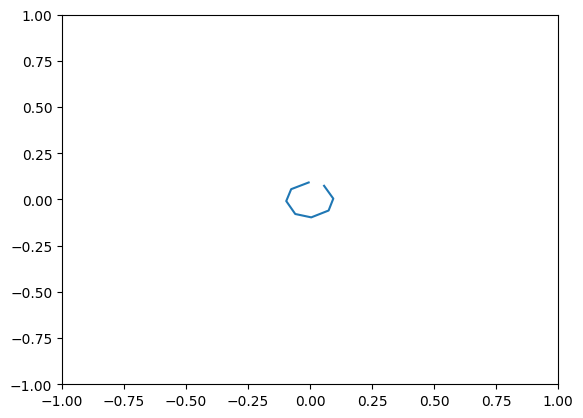

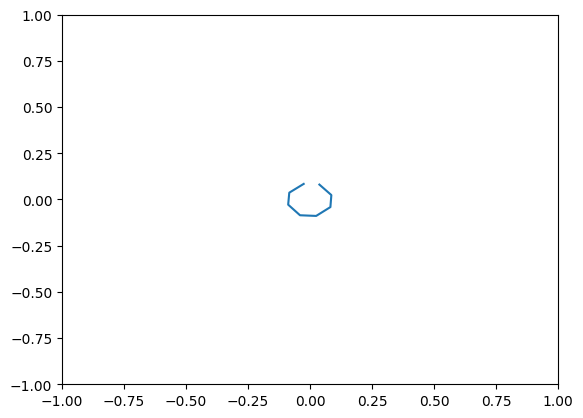

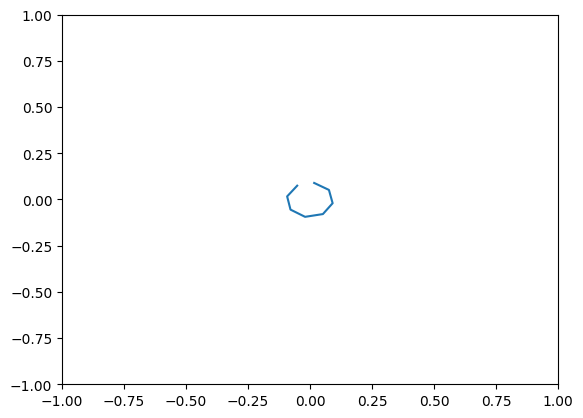

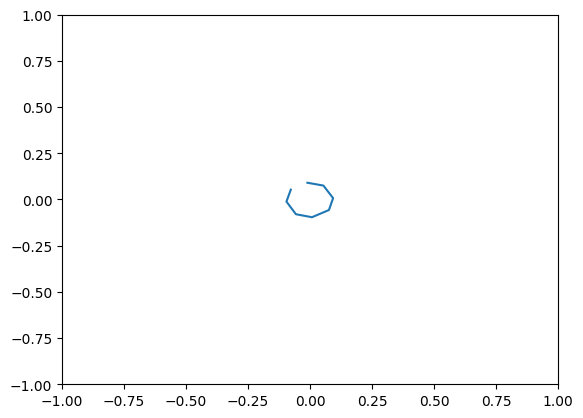

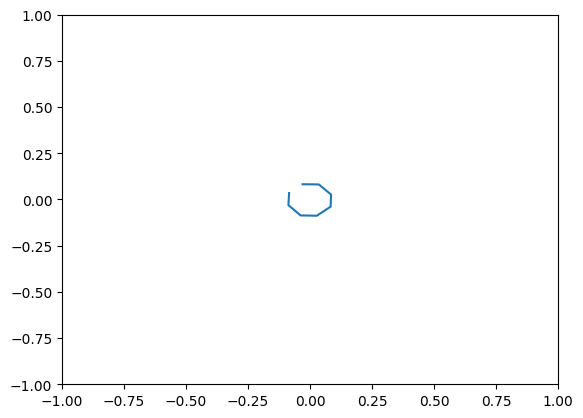

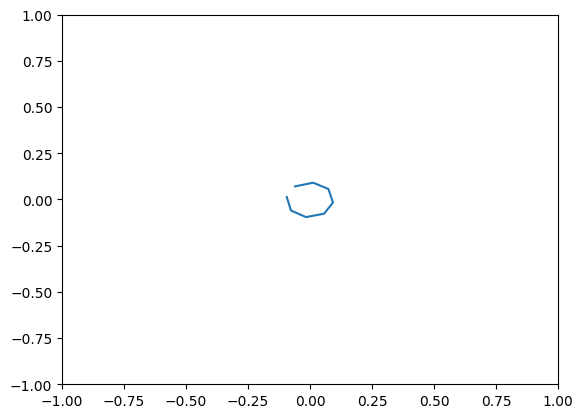

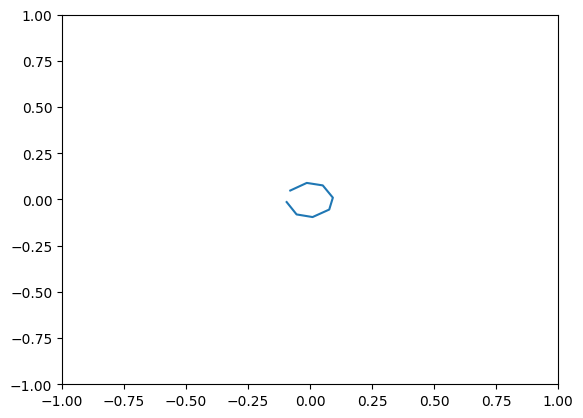

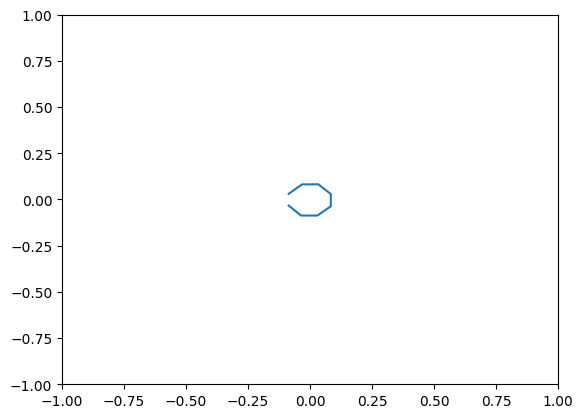

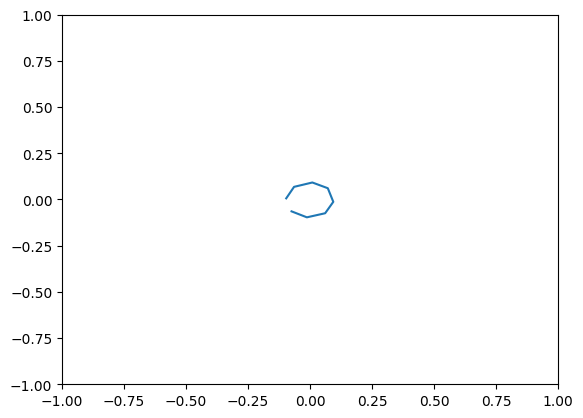

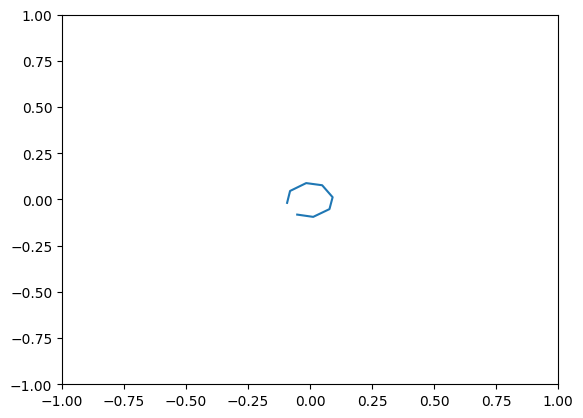

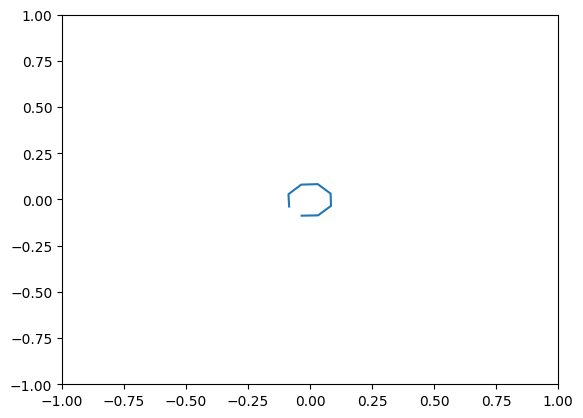

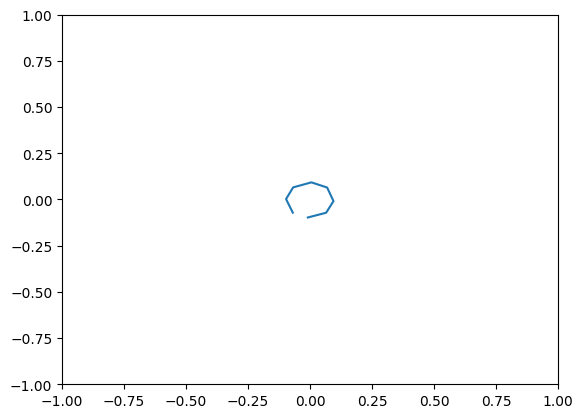

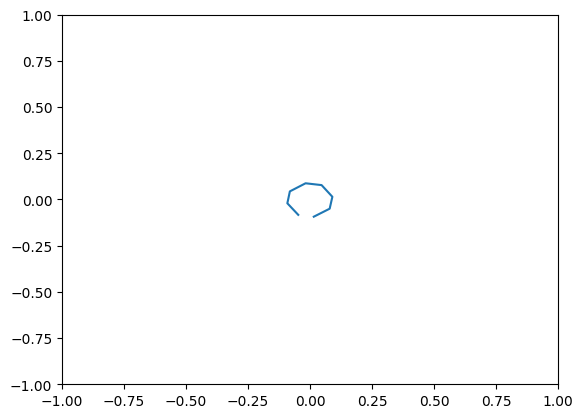

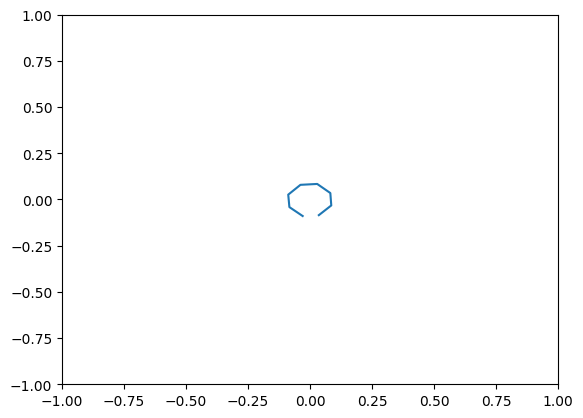

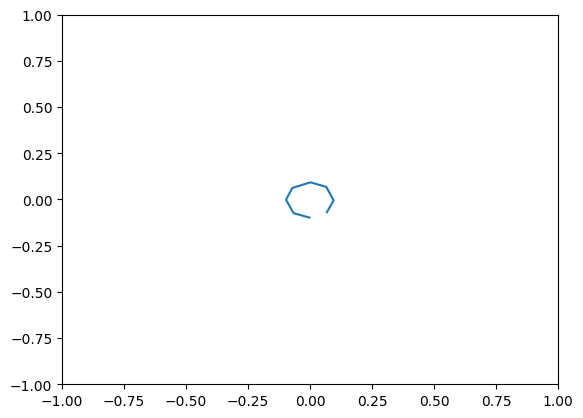

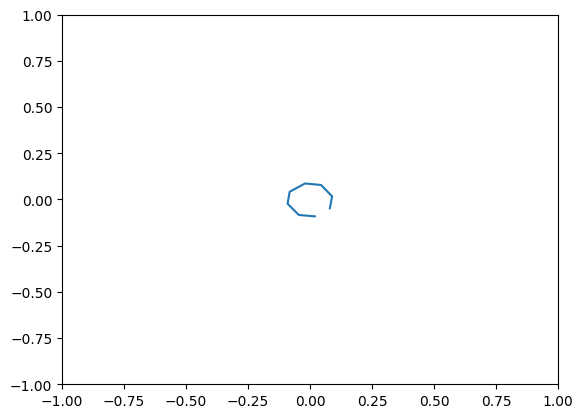

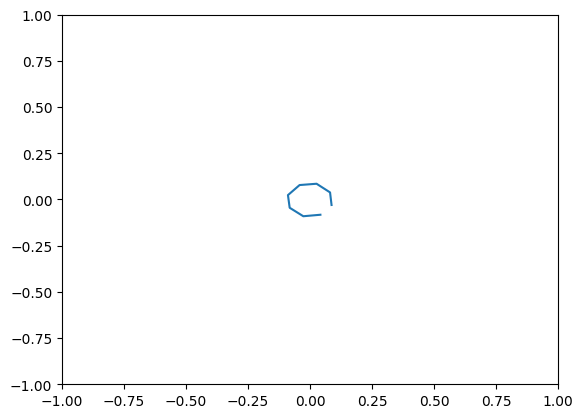

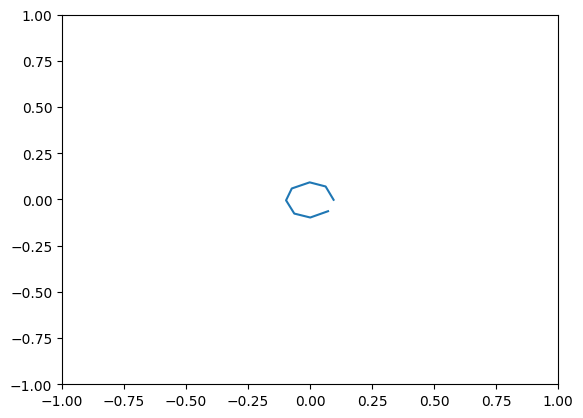

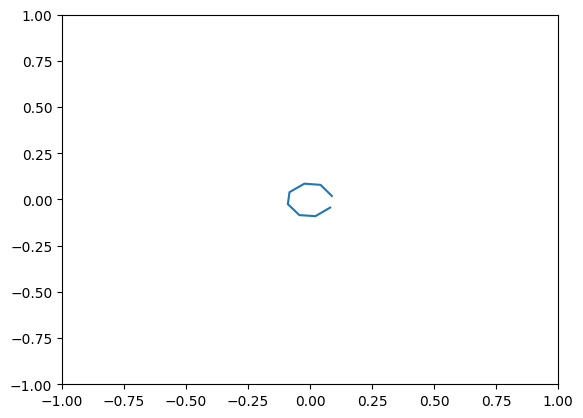

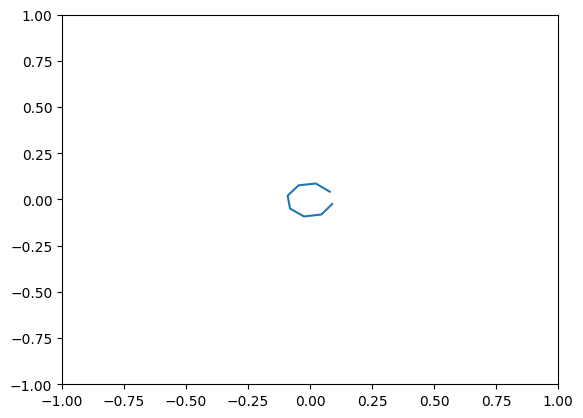

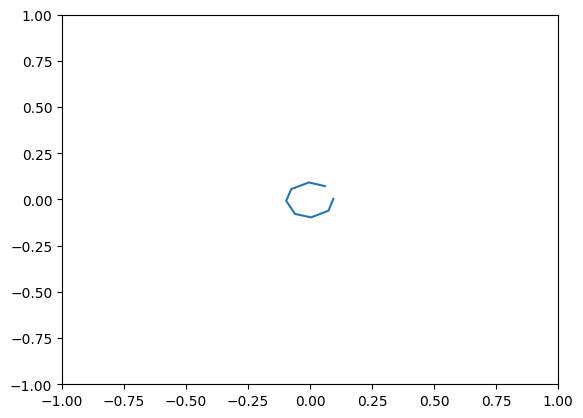

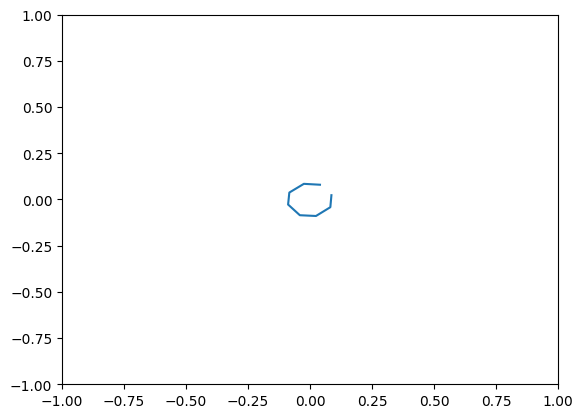

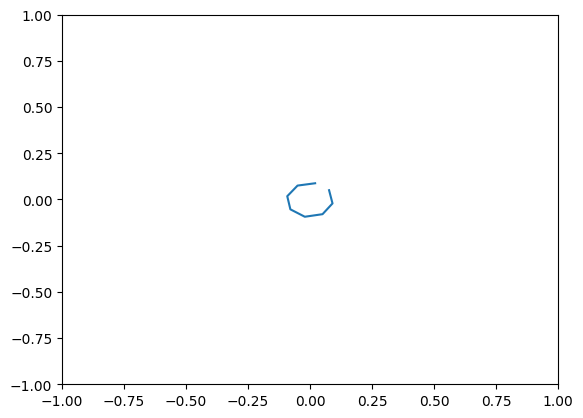

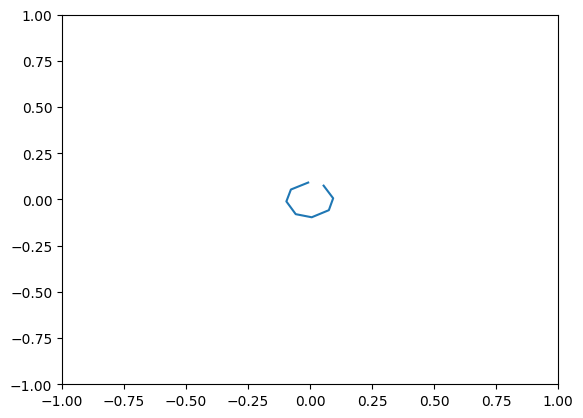

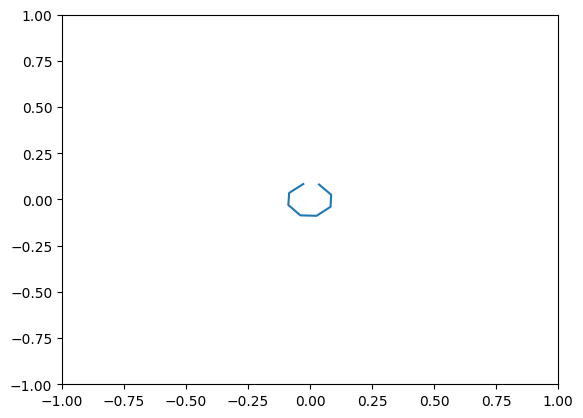

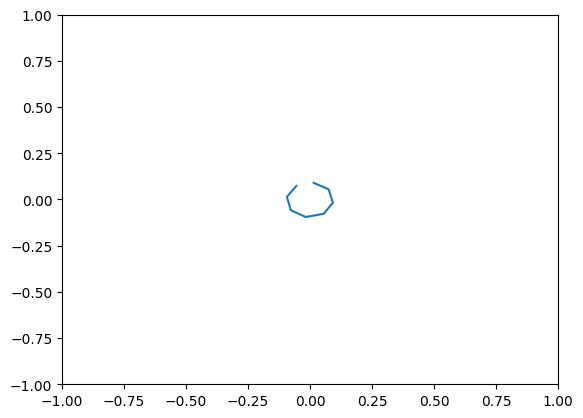

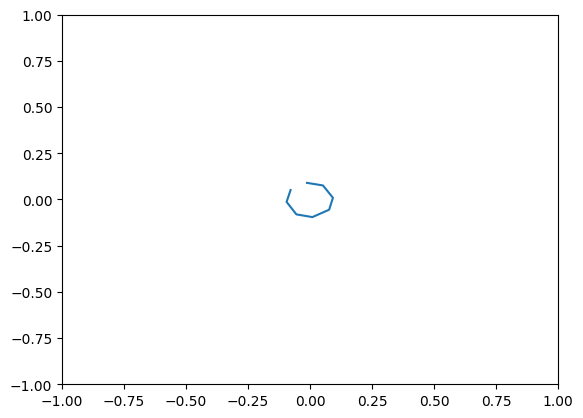

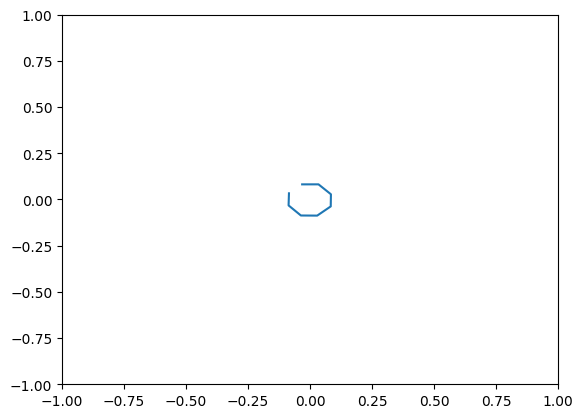

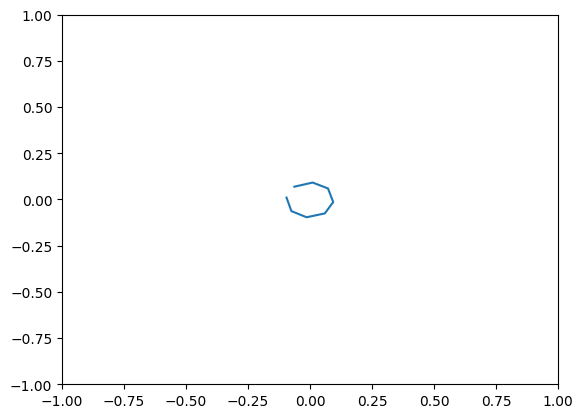

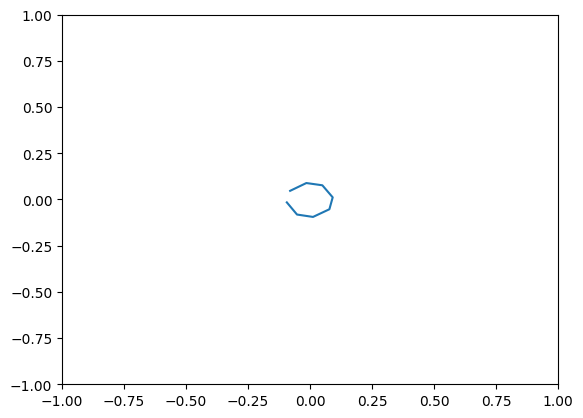

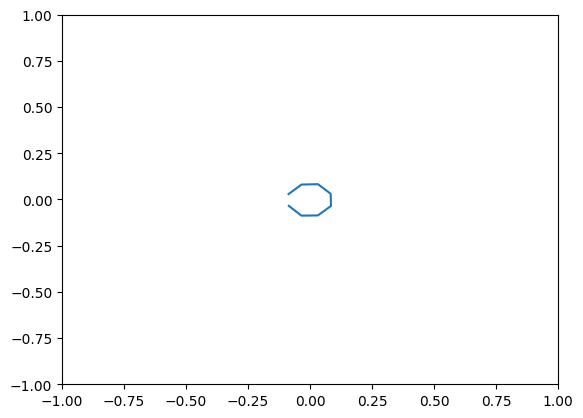

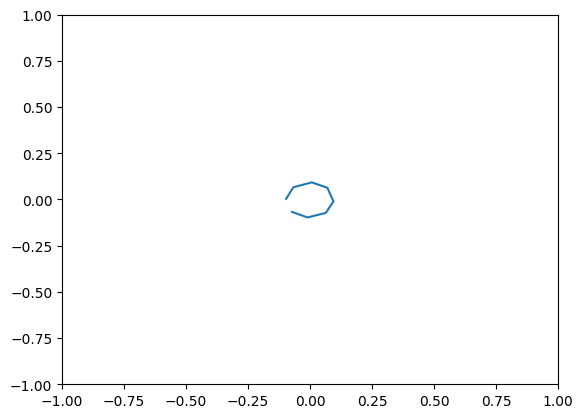

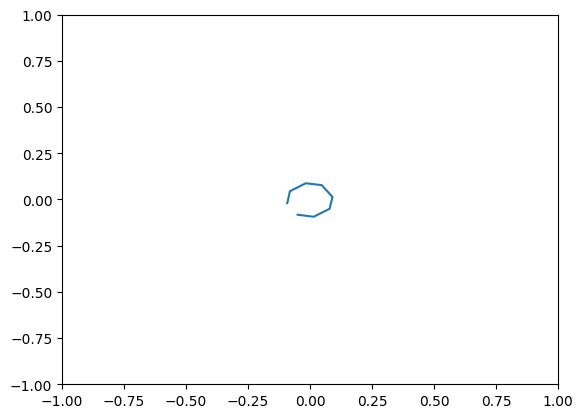

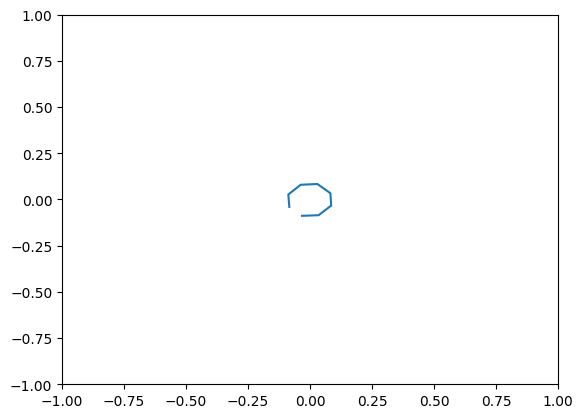

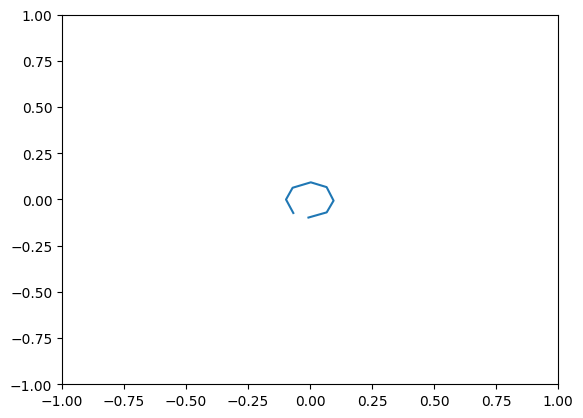

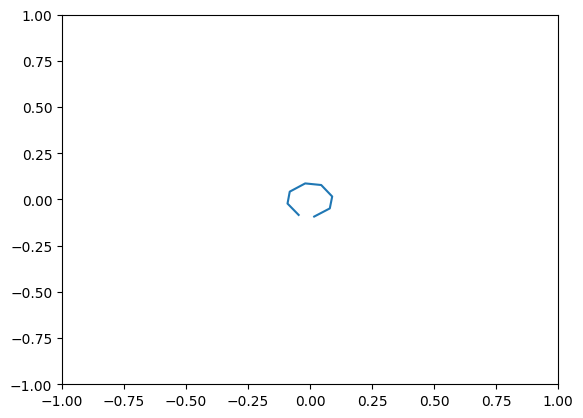

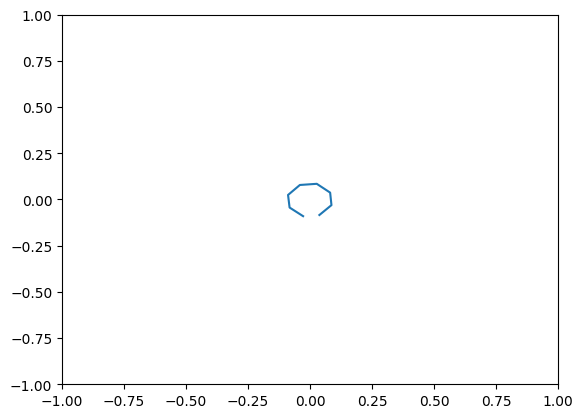

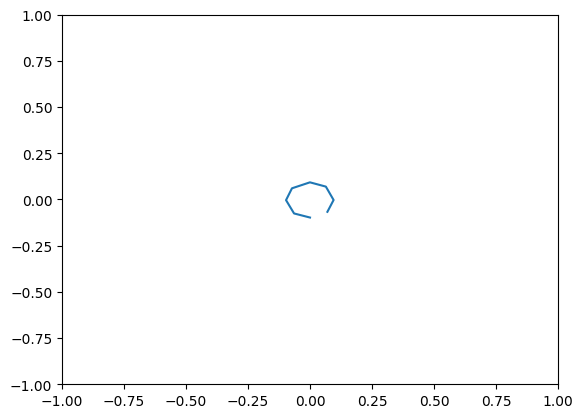

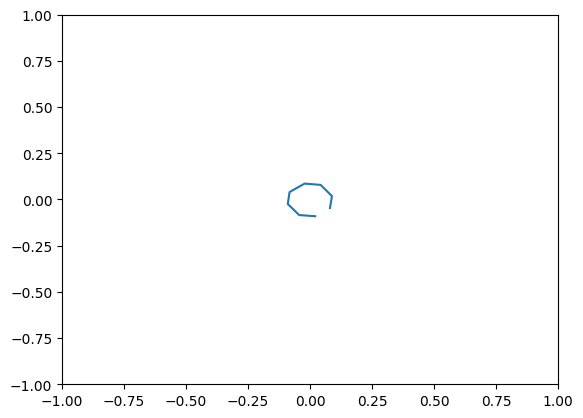

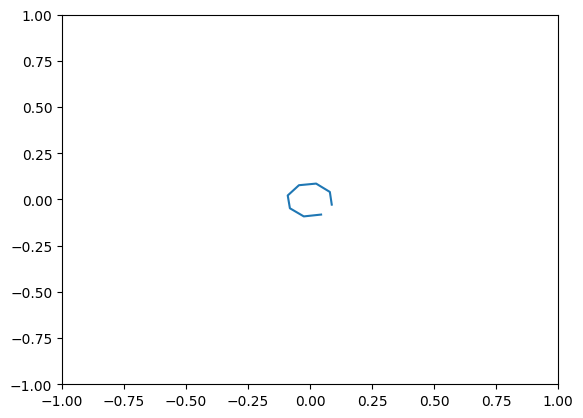

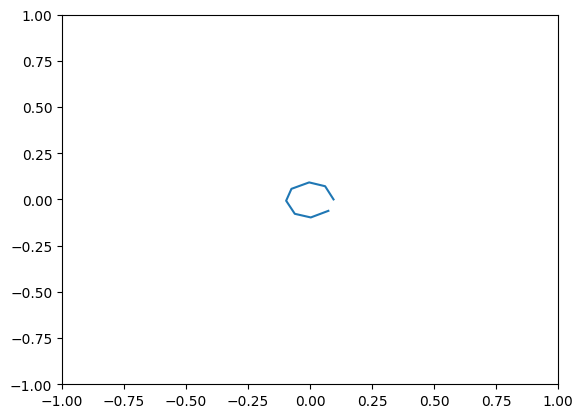

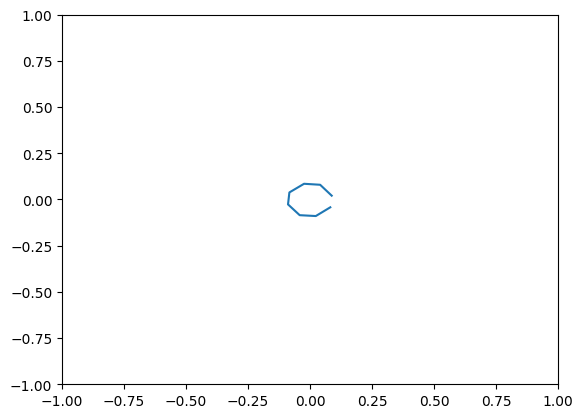

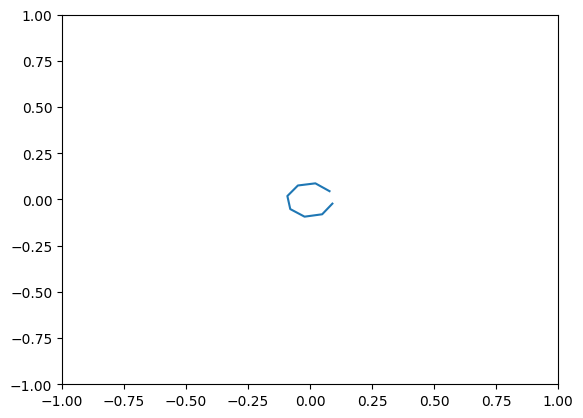

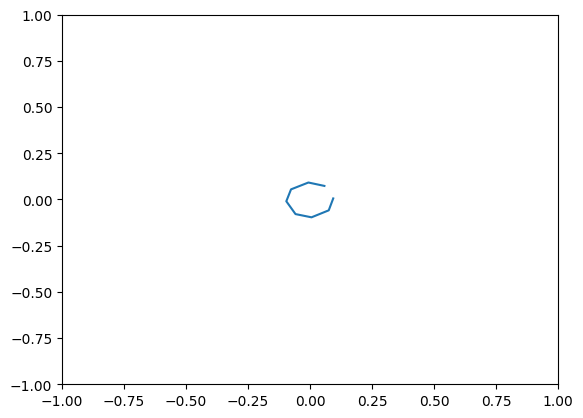

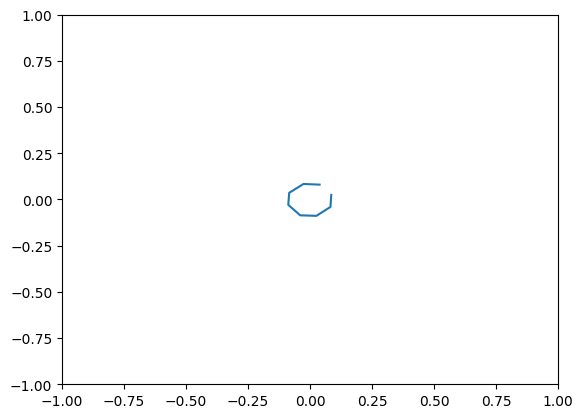

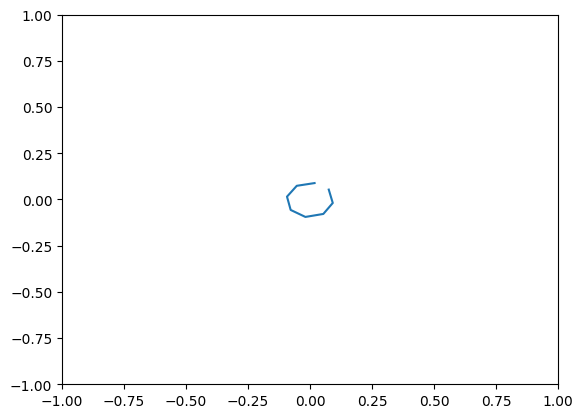

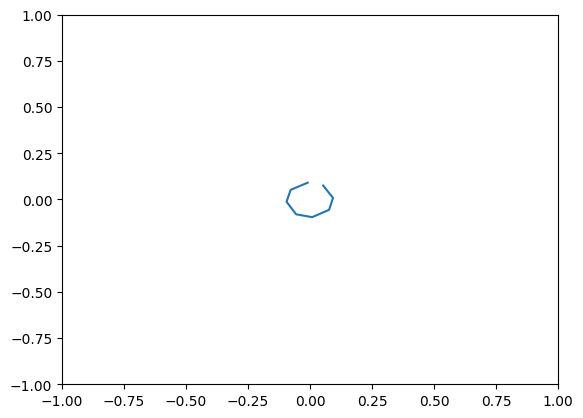

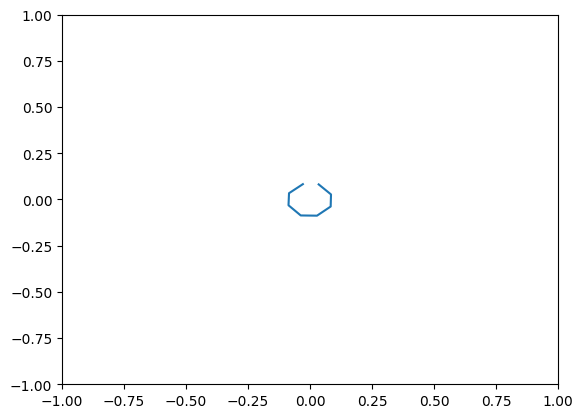

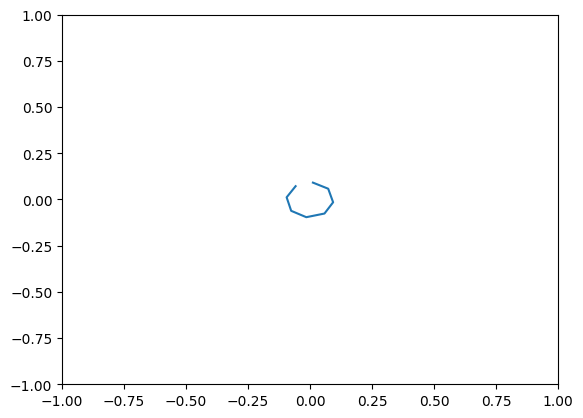

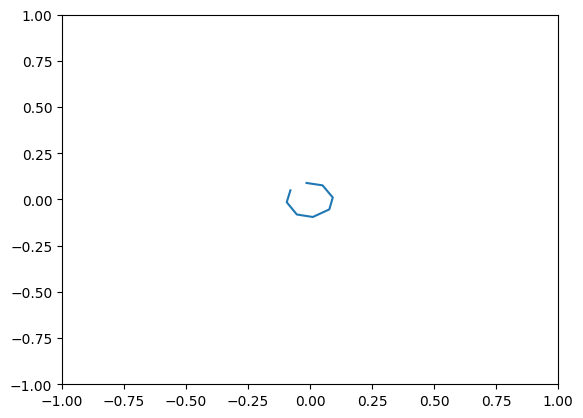

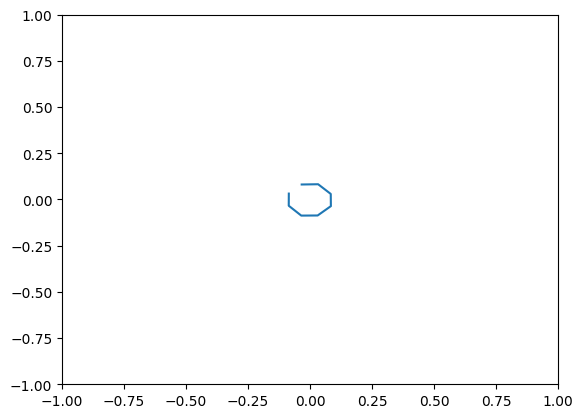

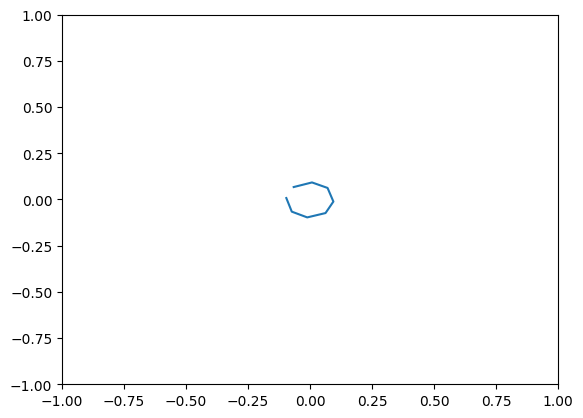

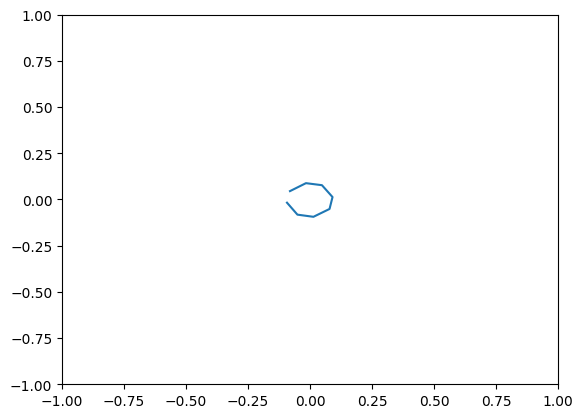

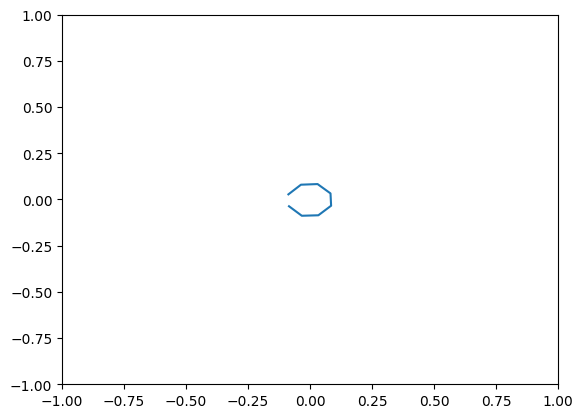

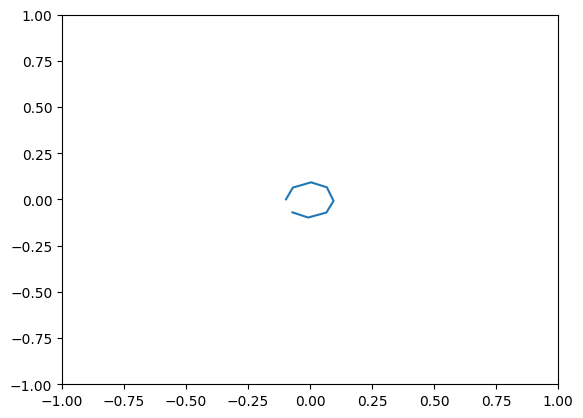

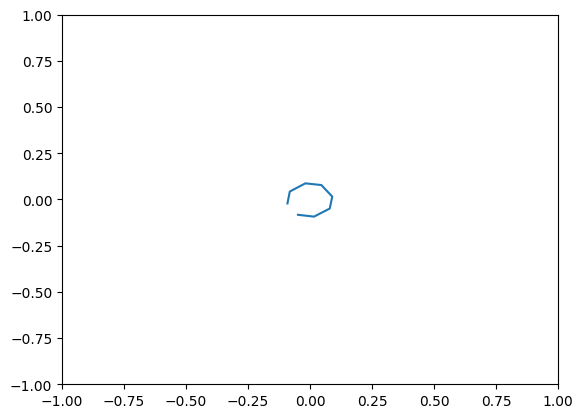

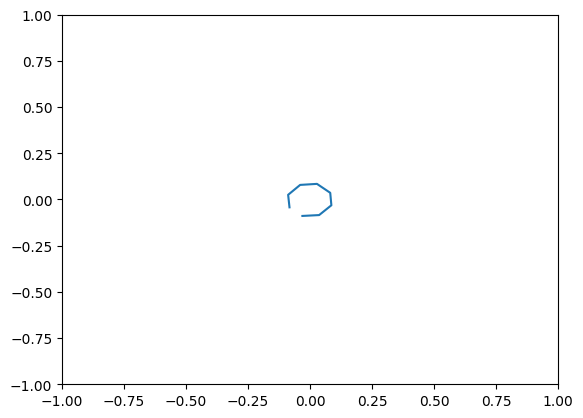

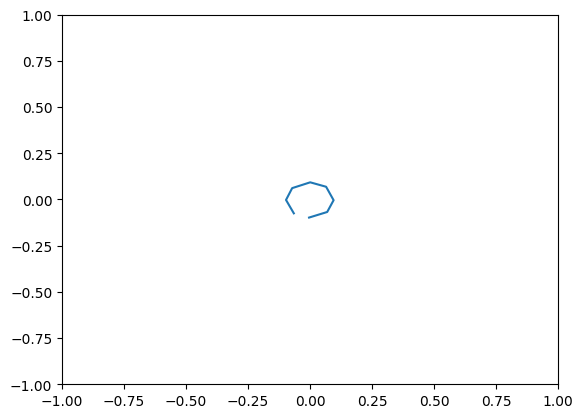

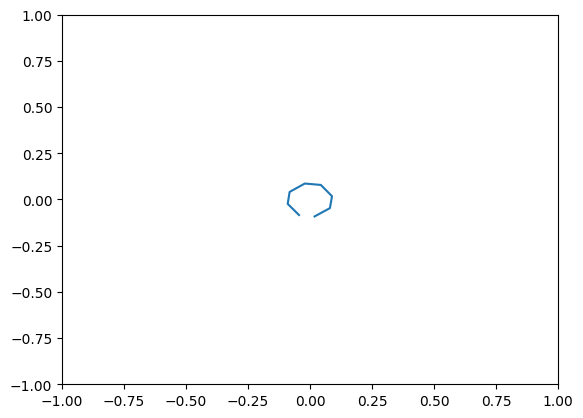

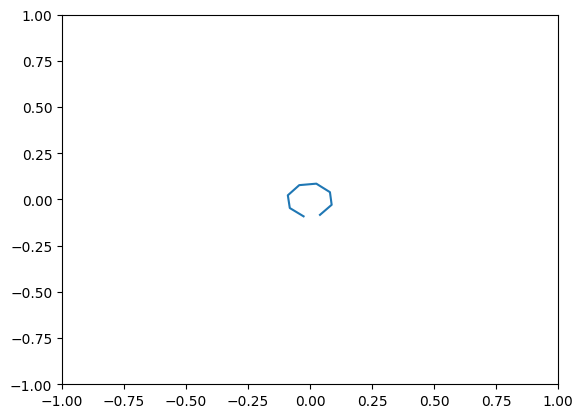

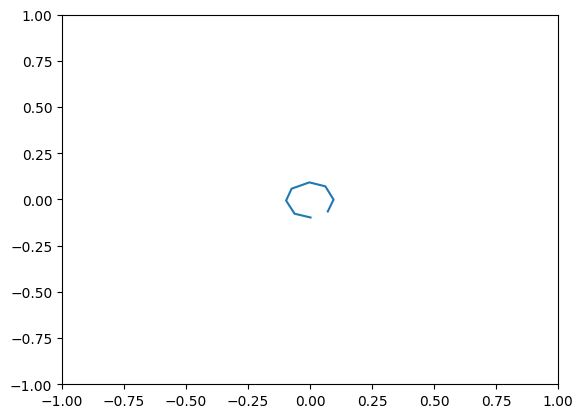

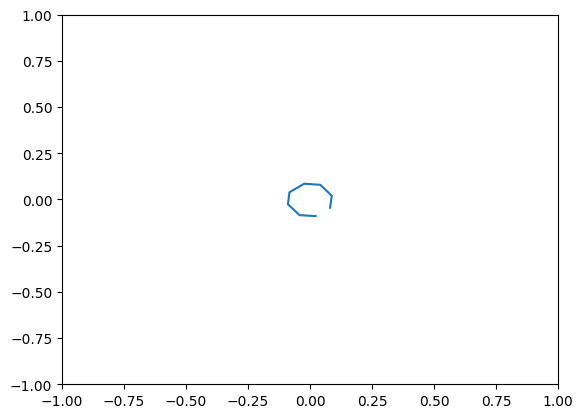

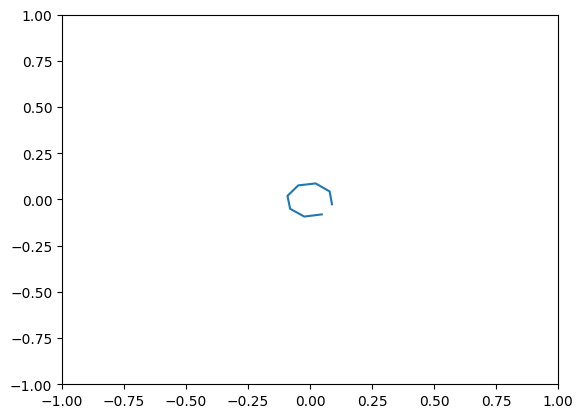

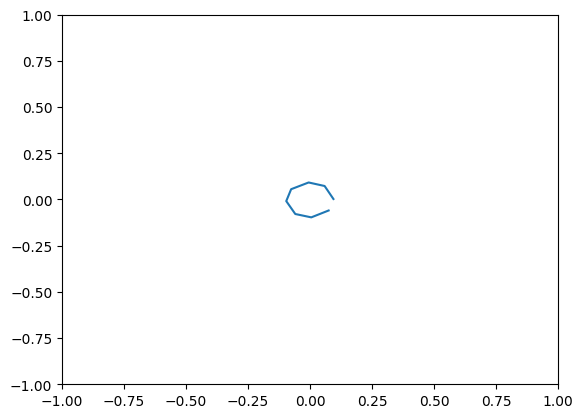

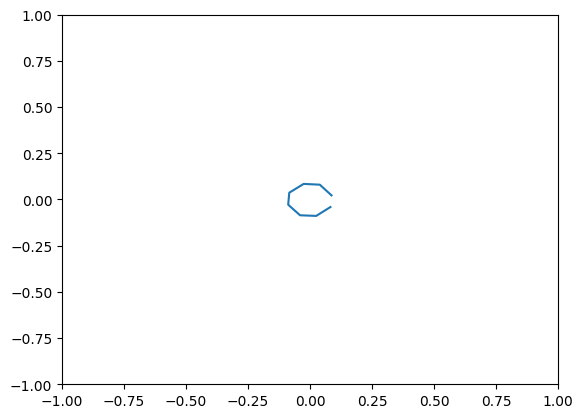

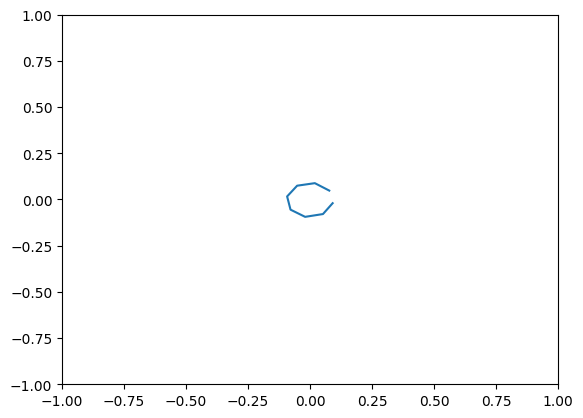

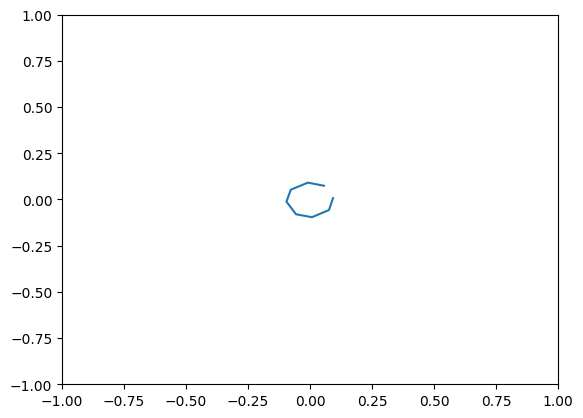

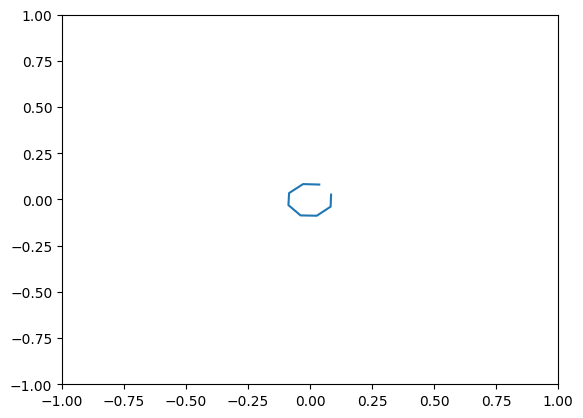

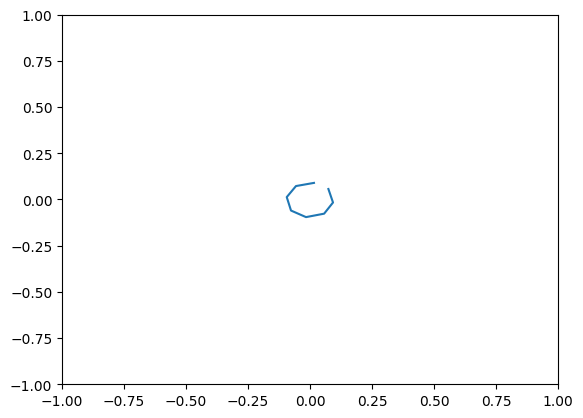

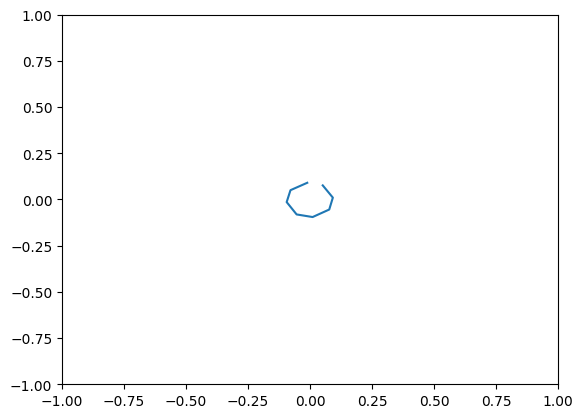

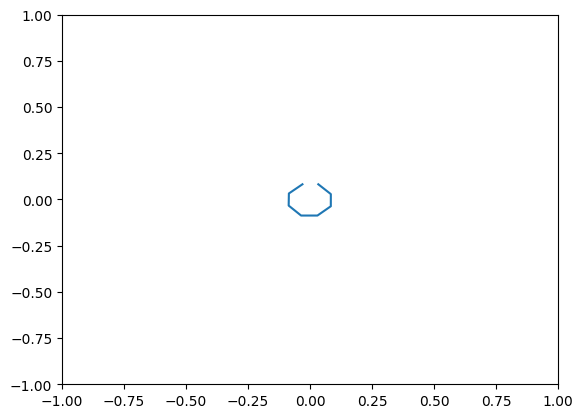

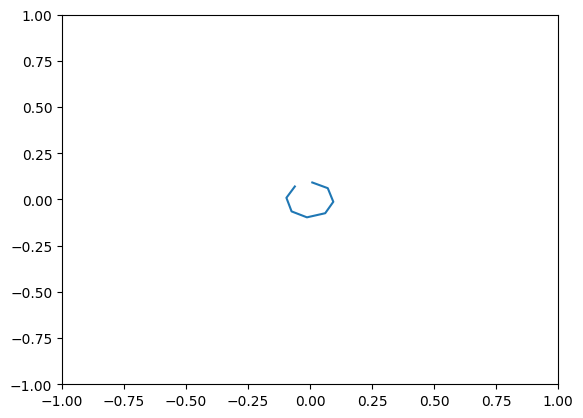

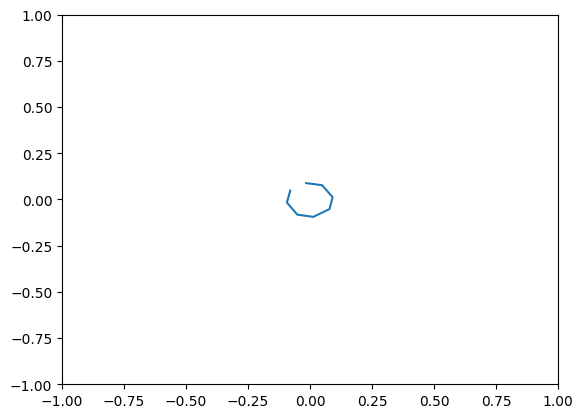

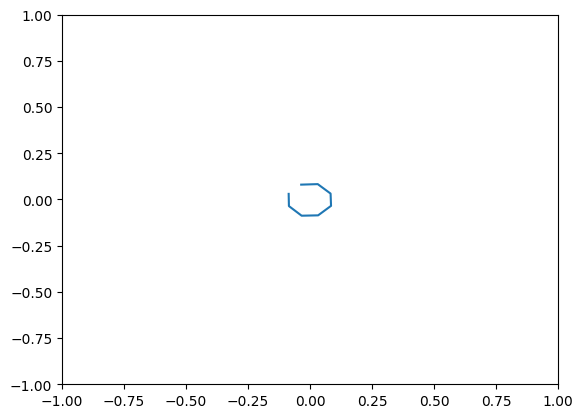

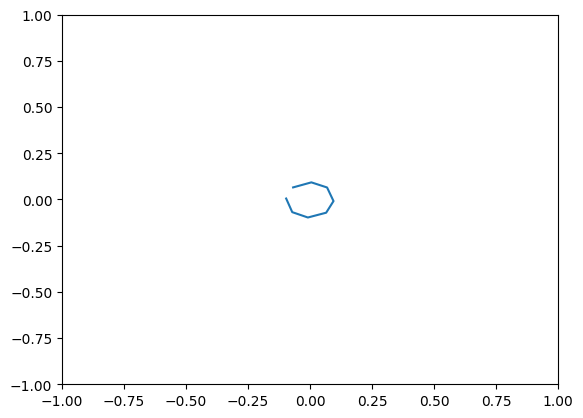

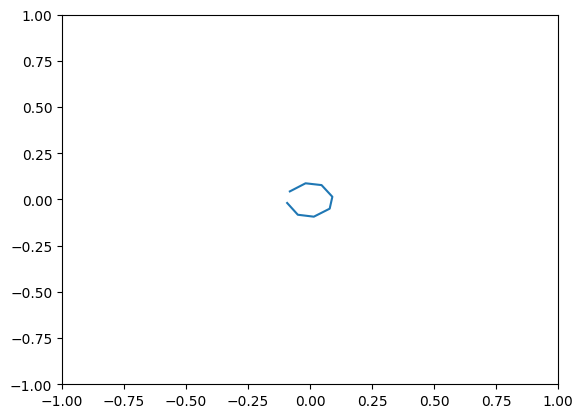

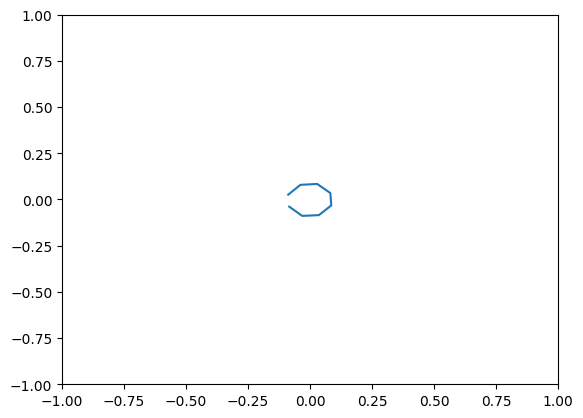

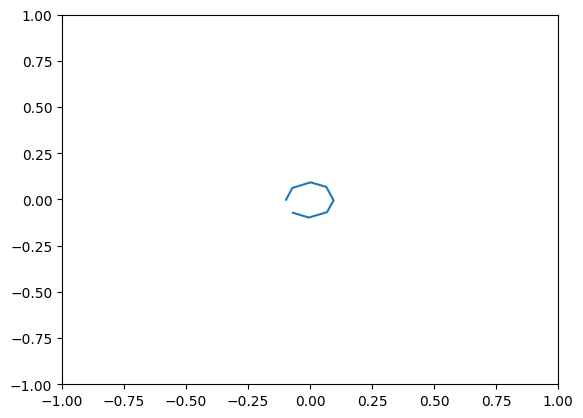

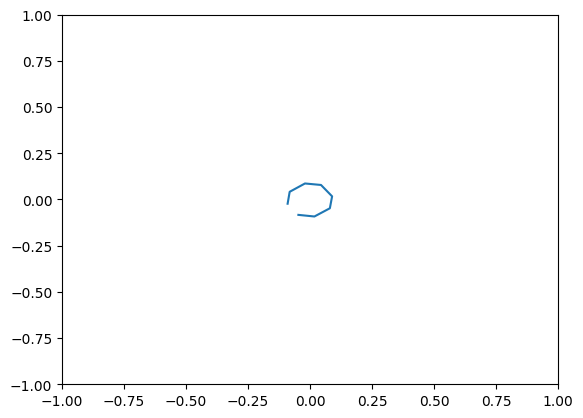

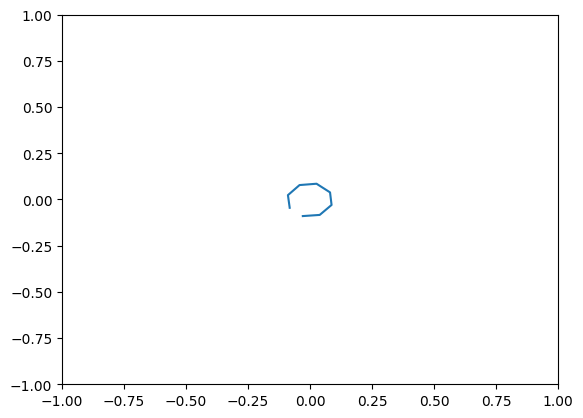

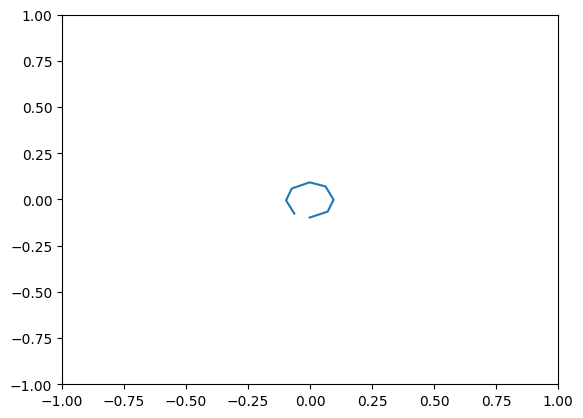

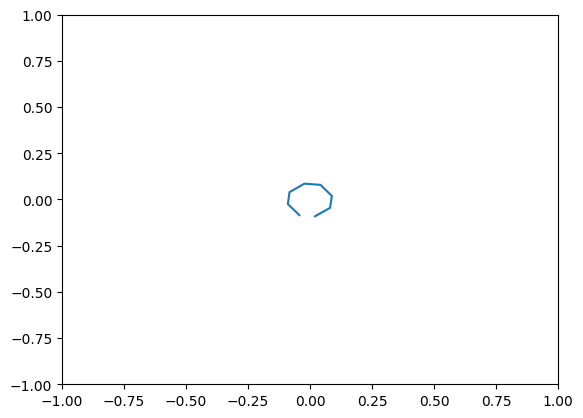

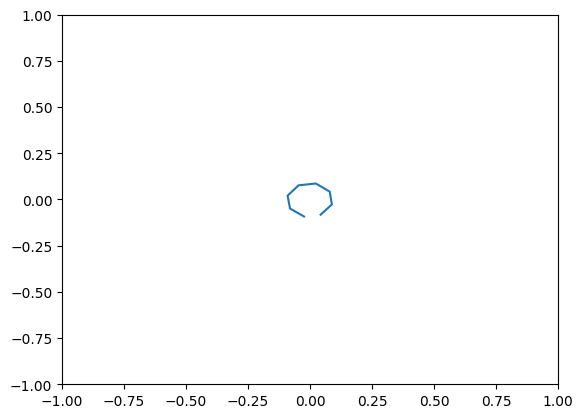

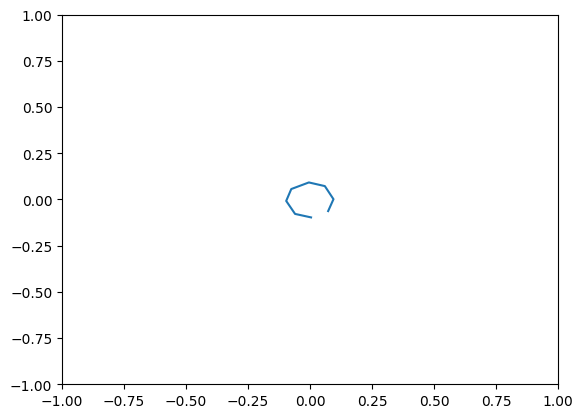

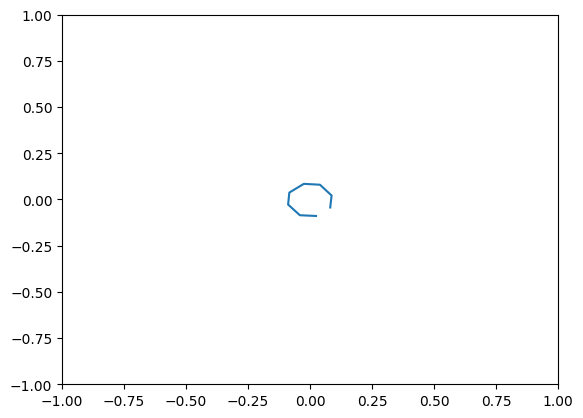

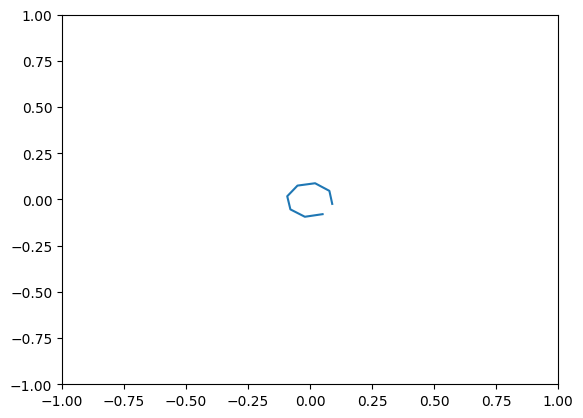

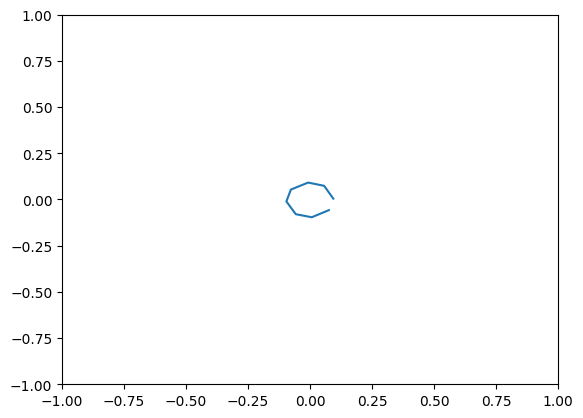

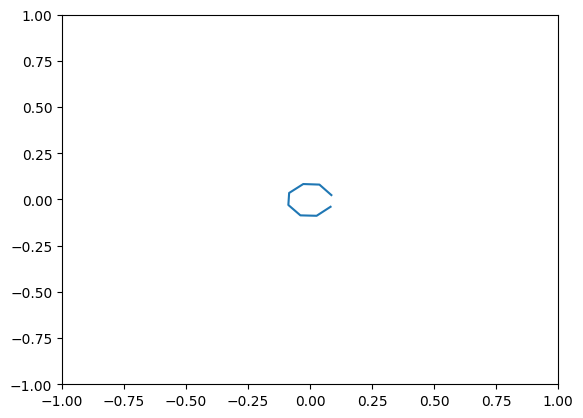

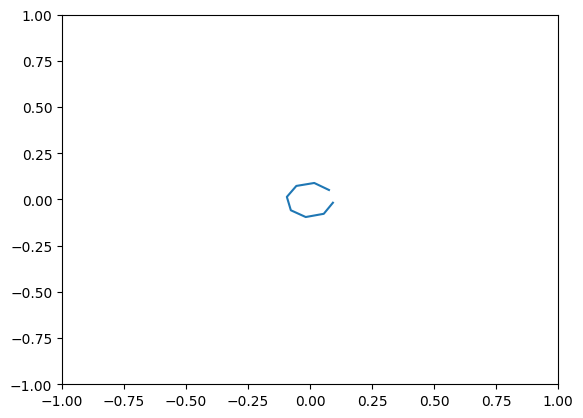

In [12]:
gradientFlow(curve, M=1000, delta_x=0.1, delta_t= 0.005, ld=0.0001)